In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import Dataset

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/산학연계/data/BISTelligen_Project_Data.csv')

In [ ]:
data.head()

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
0,1,1030.888889,1758.333333,1993.888889,438.298608,1.866068,1745.631110,0.890293
1,1,1019.508475,1742.881356,2095.932203,445.253134,1.870993,1615.059148,0.913187
2,1,1025.300000,1737.666667,2083.500000,452.722338,1.869140,1714.612494,0.888425
3,1,1019.383333,1751.666667,2089.833333,453.906117,1.853422,1689.548169,0.887922
4,1,1017.316667,1772.500000,2103.166667,447.134201,1.858652,1615.978827,0.881195


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1764 entries, 0 to 1763
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              1764 non-null   int64  
 1   Pressure         1764 non-null   float64
 2   Power1           1764 non-null   float64
 3   Power2           1764 non-null   float64
 4   Vibration_Peak1  1764 non-null   float64
 5   Vibration_RMS1   1764 non-null   float64
 6   Vibration_Peak2  1764 non-null   float64
 7   Vibration_RMS2   1764 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 110.4 KB


# Preprocessing

### Vibration_RMS2 noise data 전처리

In [ ]:
data[data['Vibration_RMS2'] < 0]

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
982,4,1027.24236,1761.611228,2055.250646,460.673714,1.860608,1771.662869,-0.000035


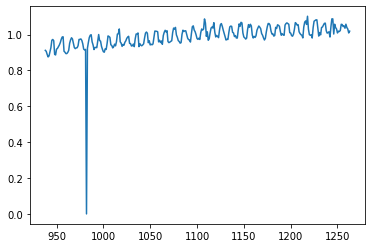

In [ ]:
plt.plot(data[data['key']==4]['Vibration_RMS2'])

In [ ]:
# 삭제
# data.drop(data[data['Vibration_RMS2'] < 0].index[0],axis=0,inplace=True)
# data.reset_index(drop=True,inplace=True)

In [ ]:
# key4의 Vibration_RMS2 평균값 이용 대체
# data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']=data[data['key']==4]['Vibration_RMS2'].mean()

In [ ]:
# noise data 발생 지점 기준으로 이전 40개 인덱스, 이후 40개 인덱스에 대한 Vibration_RMS2 평균값으로 대체
# noise data index=982, index 942~981(40개), index 983~1022(40개)
prev_sum=data[data['key']==4].loc[942:981]['Vibration_RMS2'].sum()
after_sum=data[data['key']==4].loc[983:1022]['Vibration_RMS2'].sum()
aver=(prev_sum+after_sum)/80
data.loc[data['Vibration_RMS2']<0,'Vibration_RMS2']=aver

### key별 정상/이상 데이터 나누기

In [ ]:
sum1 = 0
total = 0
for i in range(len(data)):
    total += 1
    sum1 += 1
    if (i == len(data) - 1) :
        print(str(int(data.iloc[i]['key'])) + '값의 개수 : ' + str(sum1))
        print('전체 데이터셋 행개수 : ' + str(total))
        break
    else :
        if (data.iloc[i]['key'] == data.iloc[i + 1]['key']) :
              continue
        else :
            print(str(int(data.iloc[i]['key'])) + '값의 개수 : ' + str(sum1))
            sum1 = 0

1값의 개수 : 330
2값의 개수 : 300
3값의 개수 : 308
4값의 개수 : 326
5값의 개수 : 250
6값의 개수 : 250
전체 데이터셋 행개수 : 1764


In [ ]:
def normal_select(data, num, start_key=1, end_key=6):
    correct_dataframe = pd.DataFrame()
    for key in range(start_key,end_key+1):
        new_df = data[data['key']==key][:num]
        correct_dataframe = pd.concat([correct_dataframe,new_df])
    #정상치만 모은 데이터프레임
    normal_index=correct_dataframe.index
    correct_dataframe.reset_index(drop=True, inplace=True)
    correct_dataframe.head()
    return correct_dataframe,normal_index

In [ ]:
#전체 key에 대한 정상 범주 지정
normal_df,normal_index=normal_select(data, 120)
normal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   key              720 non-null    int64  
 1   Pressure         720 non-null    float64
 2   Power1           720 non-null    float64
 3   Power2           720 non-null    float64
 4   Vibration_Peak1  720 non-null    float64
 5   Vibration_RMS1   720 non-null    float64
 6   Vibration_Peak2  720 non-null    float64
 7   Vibration_RMS2   720 non-null    float64
dtypes: float64(7), int64(1)
memory usage: 45.1 KB


### Data Scaling

In [ ]:
for col in normal_df.columns:
    print('{} skew: {}'.format(col,normal_df[col].skew()))

key skew: 0.0
Pressure skew: -0.2672133459527966
Power1 skew: 0.07262970506412862
Power2 skew: 0.40317886858866336
Vibration_Peak1 skew: 0.23643790805559217
Vibration_RMS1 skew: -0.696762316128699
Vibration_Peak2 skew: 0.026705761709008517
Vibration_RMS2 skew: -0.04292533164746037


In [ ]:
for col in normal_df.columns:
    print('{} skew: {}'.format(col,normal_df[col].kurt()))

key skew: -1.269045349121805
Pressure skew: 0.89942363445217
Power1 skew: -0.5382606425032939
Power2 skew: -1.3255167720731251
Vibration_Peak1 skew: -0.2016976539294939
Vibration_RMS1 skew: 0.06902672135511256
Vibration_Peak2 skew: -0.5100600252146341
Vibration_RMS2 skew: -0.35068059199981105


In [ ]:
# scaling 전
normal_df.describe()

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,3.500000,1019.955706,1778.552372,2129.844696,471.634095,1.849539,1725.622943,0.957347
std,1.709012,4.684643,20.744504,120.548240,14.541507,0.026617,69.409833,0.042870
min,1.000000,1003.600000,1721.383746,1904.865277,432.384464,1.757011,1543.133416,0.846306
25%,2.000000,1017.300716,1763.066897,2037.583333,461.540144,1.832898,1678.656216,0.929338
50%,3.500000,1020.025087,1778.769135,2068.943545,470.477847,1.855762,1723.850588,0.957957
75%,5.000000,1022.596913,1792.147740,2270.461198,481.298629,1.868093,1781.908844,0.987505
max,6.000000,1034.297400,1831.814318,2394.081072,514.049482,1.911388,1905.253163,1.092070


In [ ]:
scaler=MinMaxScaler()
train_data=pd.DataFrame(scaler.fit_transform(normal_df.drop(['key'],axis=1)),columns=normal_df.columns[1:])
# scaling 후
train_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.532804,0.517688,0.459878,0.480617,0.599364,0.503948,0.451819
std,0.152607,0.187851,0.246411,0.178063,0.172417,0.191676,0.174435
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.446315,0.377460,0.271287,0.357016,0.491566,0.374249,0.337849
50%,0.535064,0.519651,0.335390,0.466459,0.639669,0.499054,0.454301
75%,0.618844,0.640801,0.747310,0.598961,0.719545,0.659383,0.574529
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# train data(정상만 모아놓은 df)
train_data.head()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
0,0.888964,0.334596,0.181972,0.072420,0.706432,0.559201,0.178978
1,0.518235,0.194671,0.390558,0.157579,0.738332,0.198624,0.272134
2,0.706900,0.147449,0.365145,0.249040,0.726331,0.473542,0.171378
3,0.514159,0.274226,0.378091,0.263536,0.624510,0.404327,0.169331
4,0.446835,0.462881,0.405345,0.180613,0.658390,0.201164,0.141961


In [ ]:
# test data (전체 데이터셋)
test_data=data.drop(['key'],axis=1)
test_data=pd.DataFrame(scaler.transform(test_data),columns=test_data.columns)
test_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,0.846586,0.676493,0.530067,0.500236,0.661216,0.625545,0.620327
std,1.005207,0.509817,0.355994,0.179688,0.280534,0.243716,0.236706
min,0.000000,-0.047746,-0.000925,0.000000,0.000000,0.000000,0.000000
25%,0.479786,0.425178,0.276051,0.371938,0.524935,0.466149,0.472118
50%,0.579528,0.578216,0.382733,0.488849,0.652257,0.612388,0.604436
75%,0.750614,0.750507,0.775781,0.619776,0.739235,0.751196,0.780843
max,8.403888,4.586750,2.738006,1.071815,2.978500,2.045444,2.059179


In [ ]:
test_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,0.846586,0.676493,0.530067,0.500236,0.661216,0.625545,0.620327
std,1.005207,0.509817,0.355994,0.179688,0.280534,0.243716,0.236706
min,0.000000,-0.047746,-0.000925,0.000000,0.000000,0.000000,0.000000
25%,0.479786,0.425178,0.276051,0.371938,0.524935,0.466149,0.472118
50%,0.579528,0.578216,0.382733,0.488849,0.652257,0.612388,0.604436
75%,0.750614,0.750507,0.775781,0.619776,0.739235,0.751196,0.780843
max,8.403888,4.586750,2.738006,1.071815,2.978500,2.045444,2.059179


In [ ]:
data.describe()

,key,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,3.349206,1029.587995,1796.089208,2164.182666,473.236279,1.859088,1769.655457,0.998760
std,1.680843,30.857242,56.299360,174.158013,14.674220,0.043308,88.254406,0.058174
min,1.000000,1003.600000,1716.111111,1904.412839,432.384464,1.757011,1543.133416,0.846306
25%,2.000000,1018.328190,1768.336433,2039.913975,462.758782,1.838049,1711.935295,0.962336
50%,3.000000,1021.389993,1785.236494,2092.104392,472.306302,1.857705,1764.891307,0.994855
75%,5.000000,1026.641906,1804.262637,2284.389567,482.998497,1.871132,1815.156379,1.038209
max,6.000000,1261.577503,2227.901131,3244.341245,519.914237,2.216824,2283.829118,1.352378


In [ ]:
init_train_data = normal_df.drop(['key'],axis=1)
init_test_data = data.drop(['key'],axis=1)

In [ ]:
init_train_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,1019.955706,1778.552372,2129.844696,471.634095,1.849539,1725.622943,0.957347
std,4.684643,20.744504,120.548240,14.541507,0.026617,69.409833,0.042870
min,1003.600000,1721.383746,1904.865277,432.384464,1.757011,1543.133416,0.846306
25%,1017.300716,1763.066897,2037.583333,461.540144,1.832898,1678.656216,0.929338
50%,1020.025087,1778.769135,2068.943545,470.477847,1.855762,1723.850588,0.957957
75%,1022.596913,1792.147740,2270.461198,481.298629,1.868093,1781.908844,0.987505
max,1034.297400,1831.814318,2394.081072,514.049482,1.911388,1905.253163,1.092070


In [ ]:
init_test_data.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000,1764.000000
mean,1029.587995,1796.089208,2164.182666,473.236279,1.859088,1769.655457,0.998760
std,30.857242,56.299360,174.158013,14.674220,0.043308,88.254406,0.058174
min,1003.600000,1716.111111,1904.412839,432.384464,1.757011,1543.133416,0.846306
25%,1018.328190,1768.336433,2039.913975,462.758782,1.838049,1711.935295,0.962336
50%,1021.389993,1785.236494,2092.104392,472.306302,1.857705,1764.891307,0.994855
75%,1026.641906,1804.262637,2284.389567,482.998497,1.871132,1815.156379,1.038209
max,1261.577503,2227.901131,3244.341245,519.914237,2.216824,2283.829118,1.352378


## (key split)

In [ ]:
#key 1~4, key 5~6별로 정상 범주 지정
normal_df_1to4, normal_index_1to4 = normal_select(data,120,end_key=4)
normal_df_5to6, normal_index_5to6 = normal_select(data,120,start_key=5)

In [ ]:
for col in normal_df_1to4.columns:
    print('{} skew: {}'.format(col,normal_df[col].skew()))

key skew: 0.0
Pressure skew: -0.2672133459527966
Power1 skew: 0.07262970506412862
Power2 skew: 0.40317886858866336
Vibration_Peak1 skew: 0.23643790805559217
Vibration_RMS1 skew: -0.696762316128699
Vibration_Peak2 skew: 0.026705761709008517
Vibration_RMS2 skew: -0.04292533164746037


In [ ]:
for col in normal_df_5to6.columns:
    print('{} skew: {}'.format(col,normal_df[col].skew()))

key skew: 0.0
Pressure skew: -0.2672133459527966
Power1 skew: 0.07262970506412862
Power2 skew: 0.40317886858866336
Vibration_Peak1 skew: 0.23643790805559217
Vibration_RMS1 skew: -0.696762316128699
Vibration_Peak2 skew: 0.026705761709008517
Vibration_RMS2 skew: -0.04292533164746037


In [ ]:
scaler = MinMaxScaler()
train_1to4 = pd.DataFrame(scaler.fit_transform(normal_df_1to4.drop(['key'],axis=1)),columns=normal_df_1to4.columns[1:])
train_1to4.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,480.000000,480.000000,4.800000e+02,480.000000,4.800000e+02,480.000000,4.800000e+02
mean,-0.034830,0.045833,2.142665e-01,0.042739,-1.101615e-01,-0.012593,3.735586e-02
std,0.876230,0.688346,5.211907e-01,0.753248,6.350804e-01,0.668680,6.906369e-01
min,-2.695525,-1.730902,-7.690613e-01,-1.942383,-1.959354e+00,-1.561892,-1.584236e+00
25%,-0.574978,-0.460823,-1.901101e-01,-0.461185,-6.088970e-01,-0.537759,-4.626479e-01
50%,0.000000,0.000000,9.818535e-16,0.000000,-2.341362e-15,0.000000,1.030859e-15
75%,0.425022,0.539177,8.098899e-01,0.538815,3.911030e-01,0.462241,5.373521e-01
max,2.724978,2.030021,1.343785e+00,2.119314,1.296320e+00,1.642047,2.448953e+00


In [ ]:
data_1to4 = data[data['key']<5]
test_1to4 = data_1to4.drop(['key'],axis=1)
test_1to4 = pd.DataFrame(scaler.transform(test_1to4),columns=test_1to4.columns)
test_1to4.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000,1264.000000
mean,2.533483,0.935460,0.201254,0.136079,0.179327,0.223354,0.664734
std,6.764036,2.221487,0.532097,0.783656,1.064474,0.670010,0.841992
min,-2.908757,-1.910472,-0.771015,-1.942383,-1.959354,-1.561892,-1.584236
25%,-0.255556,-0.198151,-0.200571,-0.423755,-0.427416,-0.258851,0.088319
50%,0.416853,0.429390,-0.068007,0.088589,0.109049,0.260139,0.620741
75%,1.791140,1.156246,0.829391,0.659829,0.470310,0.695508,1.310947
max,45.823998,15.519508,1.343785,2.563807,7.737669,2.084991,3.849097


In [ ]:
scaler = RobustScaler()
train_5to6 = pd.DataFrame(scaler.fit_transform(normal_df_5to6.drop(['key'],axis=1)),columns=normal_df_5to6.columns[1:])
train_5to6.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,2.400000e+02,240.000000,240.000000,2.400000e+02,240.000000,2.400000e+02,240.000000
mean,9.190218e-03,0.053919,0.278350,6.923397e-02,-0.019460,-2.418075e-02,-0.055296
std,9.933725e-01,0.689740,0.511310,6.865991e-01,0.722879,7.204666e-01,0.636455
min,-3.469565e+00,-2.013068,-0.558656,-1.594355e+00,-1.991317,-1.695001e+00,-1.316009
25%,-4.355889e-01,-0.355698,-0.100114,-4.515385e-01,-0.565994,-5.843382e-01,-0.641046
50%,1.178484e-14,0.000000,0.000000,1.365444e-15,0.000000,1.298441e-15,0.000000
75%,5.644111e-01,0.644302,0.899886,5.484615e-01,0.434006,4.156618e-01,0.358954
max,2.210988e+00,1.528652,1.137917,2.040814e+00,1.784594,1.408128e+00,1.207135


In [ ]:
data_5to6 = data[data['key']>=5]
test_5to6 = data_5to6.drop(['key'],axis=1)
test_5to6 = pd.DataFrame(scaler.transform(test_5to6),columns=test_5to6.columns)
test_5to6.describe()

,Pressure,Power1,Power2,Vibration_Peak1,Vibration_RMS1,Vibration_Peak2,Vibration_RMS2
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-0.020705,-0.004453,0.819300,0.138101,0.065446,0.976153,0.668397
std,0.959429,0.678121,1.023249,0.630597,0.726341,1.472854,1.017949
min,-3.469565,-2.013068,-0.558656,-1.594355,-1.991317,-1.695001,-1.316009
25%,-0.489083,-0.490223,-0.014076,-0.297273,-0.475205,0.012666,0.028806
50%,-0.008680,-0.021305,0.586272,0.071695,0.094545,0.688223,0.660677
75%,0.573683,0.533688,1.116790,0.555996,0.544027,1.669388,1.298960
max,2.210988,1.528652,5.036023,2.040814,2.148758,6.767435,4.983622


In [ ]:
init_train_1to4 = normal_df_1to4.drop(['key'],axis=1)
init_test_1to4 = data_1to4.drop(['key'],axis=1)

init_train_5to6 = normal_df_5to6.drop(['key'],axis=1)
init_test_5to6 = data_5to6.drop(['key'],axis=1)

# Anomaly Detection Model

### Import model 

In [ ]:
!pip3 install pyod

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 KB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-1.0.7-py3-none-any.whl size=181101 sha256=b29ef218b248bbf51f268db359960daba0d3b6166b5818535d751acea339628b
  Stored in directory: /root/.cache/pip/wheels/f7/e2/c1/1c7fd8b261e72411f6509afb429c84532e40ddcd96074473f4
Successfully built pyod


In [ ]:
from pyod.models.iforest import IForest
from pyod.models.pca import PCA
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.mcd import MCD
from sklearn.svm import OneClassSVM

### Isolation Forest

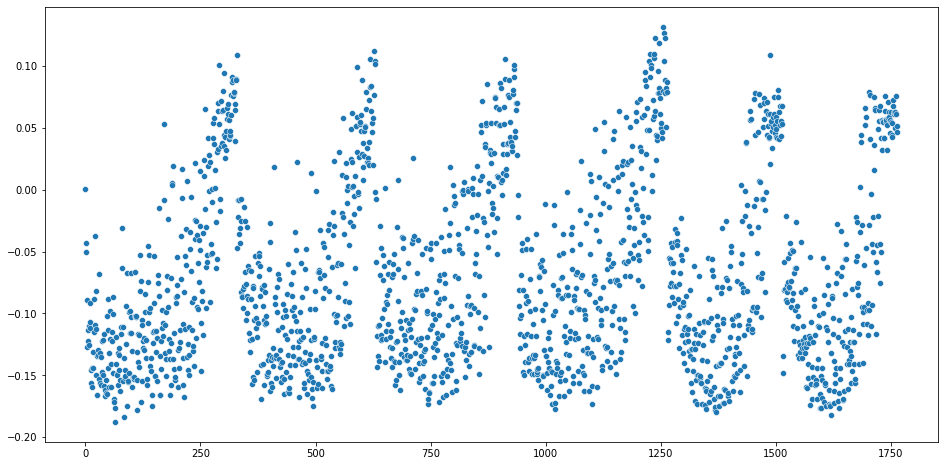

In [ ]:
# Isolation Forest 모델 구축(scaling)
plt.rcParams['figure.figsize']=(16,8)
model_iforest = IForest(contamination=0.01,random_state=42)
model_iforest.fit(train_data)
sns.scatterplot(test_data.index,model_iforest.decision_function(test_data))

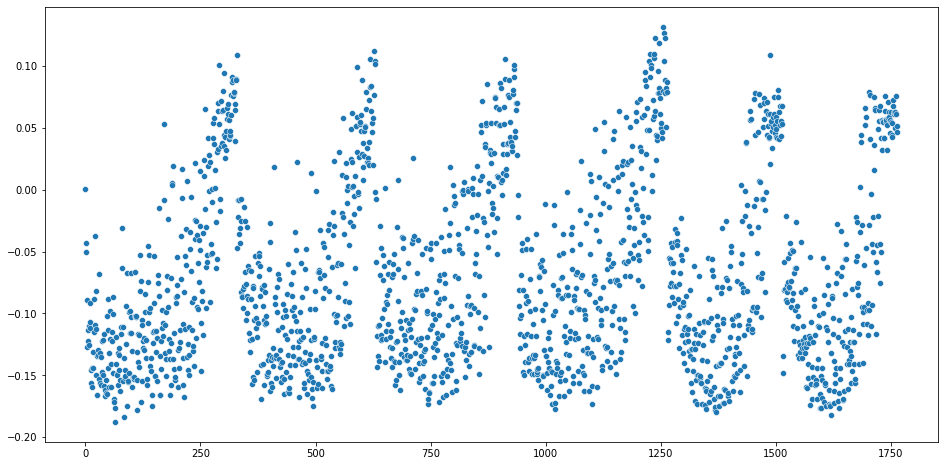

In [ ]:
# Isolation Forest 모델 구축(init)
plt.rcParams['figure.figsize']=(16,8)
model_iforest.fit(init_train_data)
sns.scatterplot(init_test_data.index,model_iforest.decision_function(init_test_data))

In [ ]:
# key1~4, key 5~6 결과 병합시킬필요
plt.rcParams['figure.figsize']=(16,8)
model_iforest.fit(train_1to4)
sns.scatterplot(test_1to4.index,model_iforest.decision_function(test_1to4))

NameError: ignored

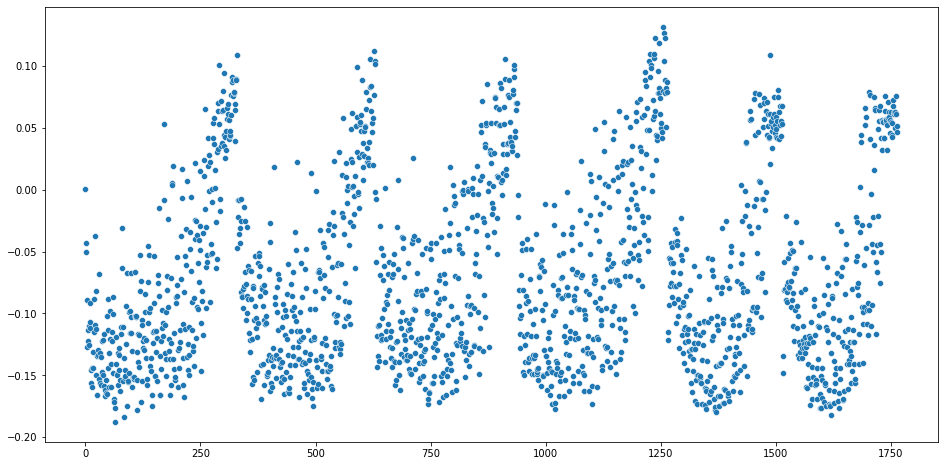

In [ ]:
plt.rcParams['figure.figsize']=(16,8)
model_iforest.fit(init_train_data)
sns.scatterplot(init_test_data.index,model_iforest.decision_function(init_test_data))

In [ ]:
# from sklearn.tree import export_graphviz

# export_graphviz(model_iforest.estimators_[1], out_file='tree.dot',max_depth=5,feature_names=test_data.columns)

# from subprocess import call
# call(['dot', '-Tpng', 'tree.dot', '-o', 'decistion-tree.png', '-Gdpi=600'])

# # jupyter notebook에서 .png 직접 출력
# from IPython.display import Image
# Image(filename = 'decistion-tree.png')

### MCD

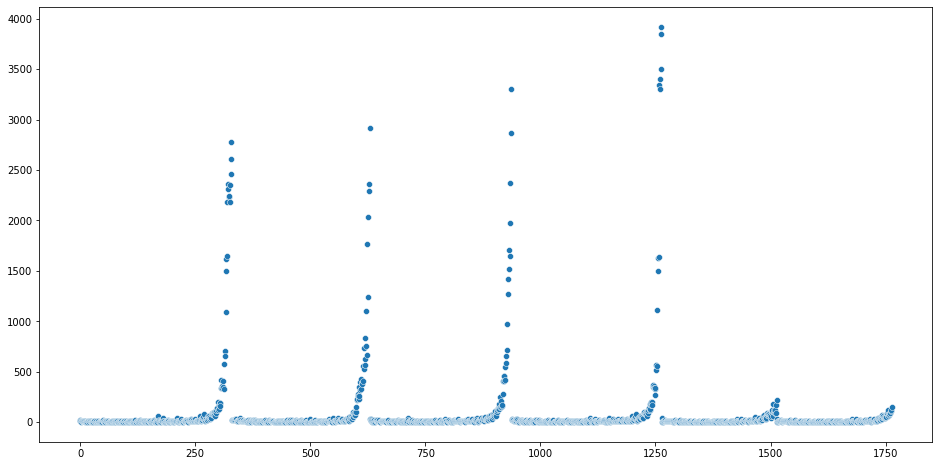

In [ ]:
# Minimum Covariance Determinant(scaling)
model_mcd = MCD(support_fraction=0.8,contamination=0.01,random_state=42)
model_mcd.fit(train_data)
sns.scatterplot(test_data.index,model_mcd.decision_function(test_data))

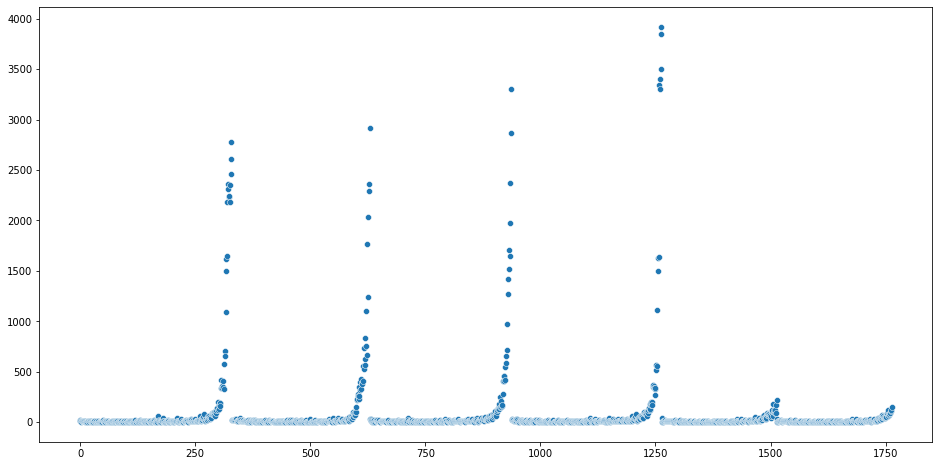

In [ ]:
# Minimum Covariance Determinant(init)
model_mcd.fit(init_train_data)
sns.scatterplot(init_test_data.index,model_mcd.decision_function(init_test_data))

### Mixture of Gaussian

In [ ]:
from sklearn.mixture import GaussianMixture

# Scaling
lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(train_data)
        bic.append(gmm.bic(train_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

covariance :  full
n_components :  4


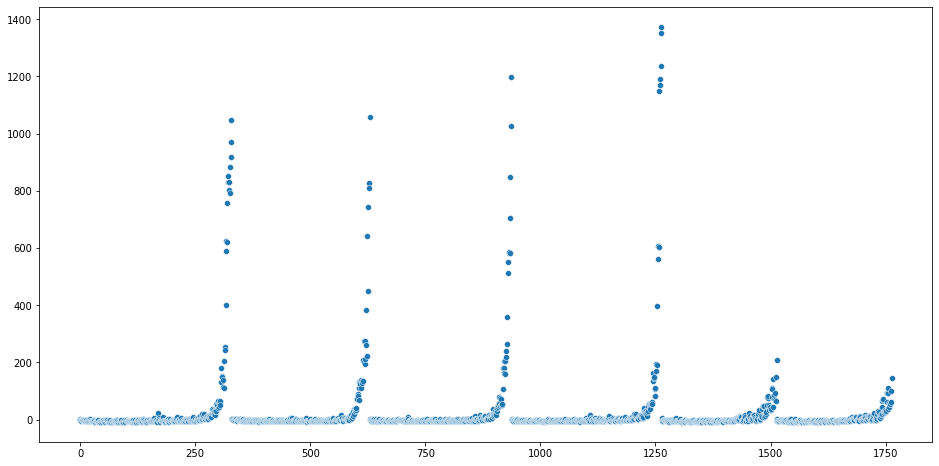

In [ ]:
score = best_gmm.score_samples(test_data)
sns.scatterplot(test_data.index,-score)

In [ ]:
# Init

lowest_bic = np.infty
bic = []
n_components_range = range(1, 5)
cv_types = ["spherical", "tied", "diag", "full"]
for cv_type in cv_types:
    for n_components in n_components_range:
        gmm = GaussianMixture(
            n_components=n_components, covariance_type=cv_type
        )
        gmm.fit(init_train_data)
        bic.append(gmm.bic(init_train_data))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm
print("covariance : ", best_gmm.covariance_type)
print("n_components : ", best_gmm.n_components)

covariance :  full
n_components :  4


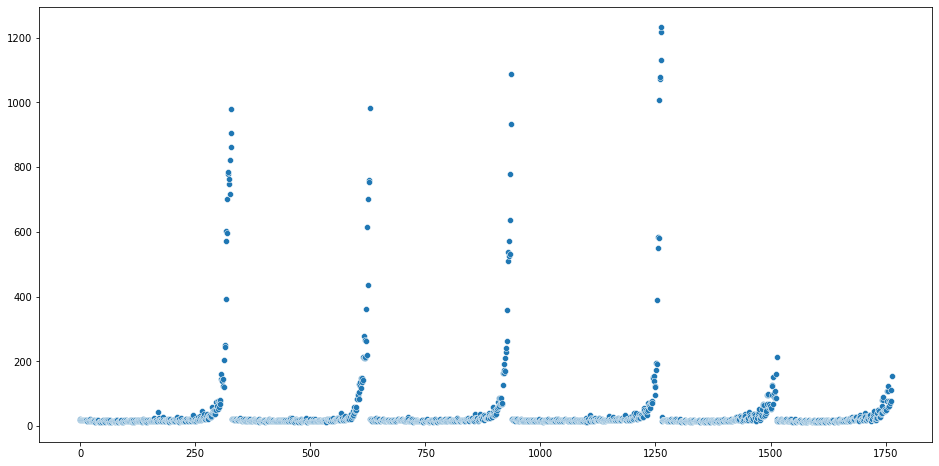

In [ ]:
score = best_gmm.score_samples(init_test_data)
sns.scatterplot(init_test_data.index,-score)

### LOF(Local Outlier Factors)

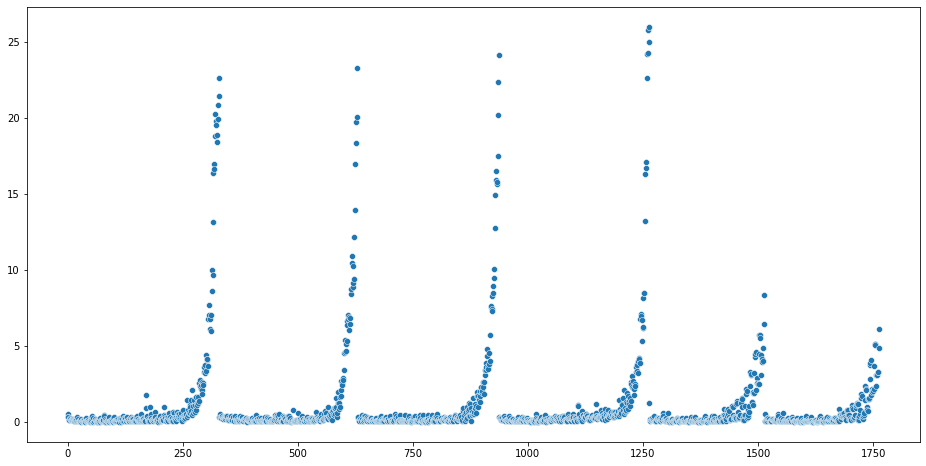

In [ ]:
# Scaling
model_lof = LocalOutlierFactor(contamination=0.01,novelty=True)

model_lof.fit(train_data)
lof_anomaly_score=np.max(model_lof.decision_function(test_data))-model_lof.decision_function(test_data)
sns.scatterplot(test_data.index,lof_anomaly_score)

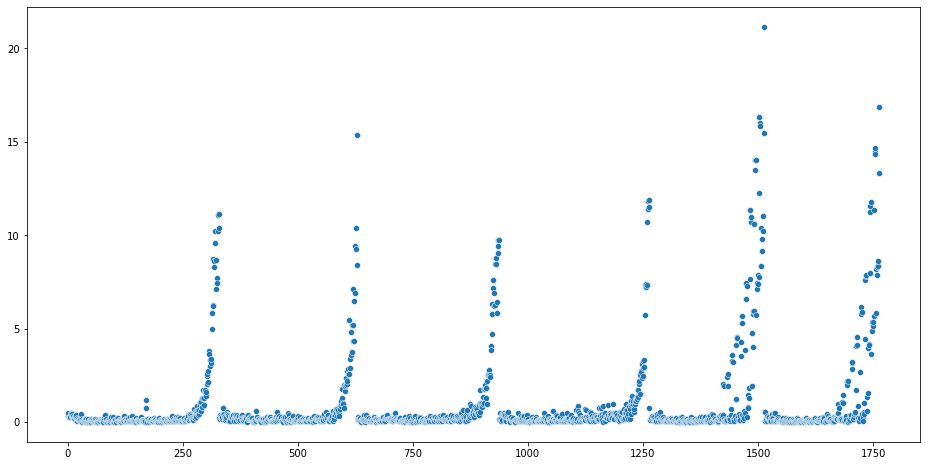

In [ ]:
# Init
model_lof.fit(init_train_data)
lof_anomaly_score=np.max(model_lof.decision_function(init_test_data))-model_lof.decision_function(init_test_data)
sns.scatterplot(init_test_data.index,lof_anomaly_score)

### OCSVM(One Class SVM)

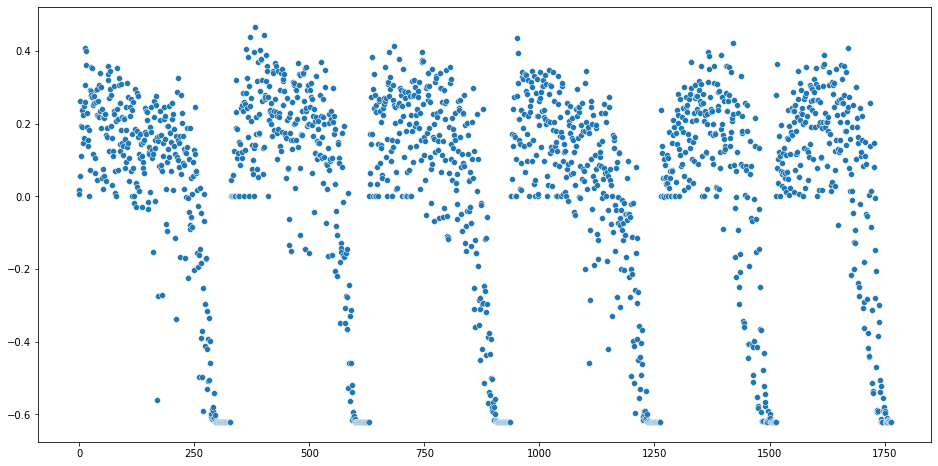

In [ ]:
# Scaling
model_ocsvm = OneClassSVM(nu=0.01)

model_ocsvm.fit(train_data)
#positive : inlier , negative : outlier
ocsvm_anomaly_score = model_ocsvm.decision_function(test_data)
sns.scatterplot(test_data.index,ocsvm_anomaly_score)

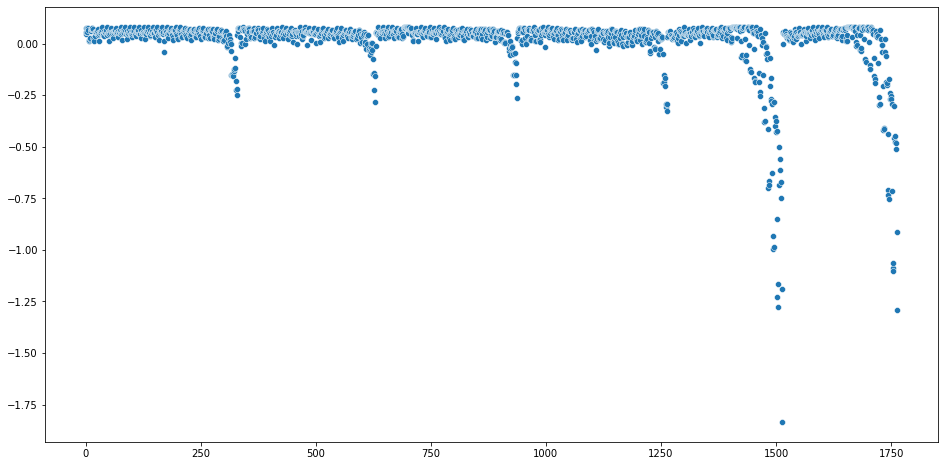

In [ ]:
# Init
model_ocsvm.fit(init_train_data)
#positive : inlier , negative : outlier
ocsvm_anomaly_score = model_ocsvm.decision_function(init_test_data)
sns.scatterplot(init_test_data.index,ocsvm_anomaly_score)

## AutoEncoder

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,losses,models
from tensorflow.keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
input_dim=train_data.shape[1]
tf.random.set_seed(2)
initializer = tf.keras.initializers.HeNormal(seed=2)
momentum = 0.9
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=10)
check_point = ModelCheckpoint('best_ae_model.h5',monitor='val_loss',mode='min',save_best_only=True)


encoder=models.Sequential([
    #input layer
    layers.InputLayer(input_shape=input_dim),

    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
])

decoder=models.Sequential([ 
    
    layers.Dense(4,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(8,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(16,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(32,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    layers.Dense(64,kernel_initializer=initializer),
    layers.BatchNormalization(momentum=momentum),
    layers.ReLU(),
    
    #output layer
    layers.Dense(input_dim,kernel_initializer=initializer),
])

model_ae=models.Sequential([
    encoder,decoder
])

model_ae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.03), 
                    loss=keras.losses.MeanSquaredError())

history = model_ae.fit(
    train_data,train_data,
    shuffle=True,
    epochs=100,
    batch_size=128,
    validation_split = 0.3,
    callbacks = [early_stopping, check_point]
)

Epoch 1/100
4/4 [==============================] - 3s 155ms/step - loss: 0.6260 - val_loss: 0.3210
Epoch 2/100
4/4 [==============================] - 0s 40ms/step - loss: 0.1201 - val_loss: 0.2599
Epoch 3/100
4/4 [==============================] - 0s 13ms/step - loss: 0.0670 - val_loss: 0.2910
Epoch 4/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0535 - val_loss: 0.1766
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0444 - val_loss: 0.0709
Epoch 6/100
4/4 [==============================] - 0s 45ms/step - loss: 0.0410 - val_loss: 0.0583
Epoch 7/100
4/4 [==============================] - 0s 39ms/step - loss: 0.0363 - val_loss: 0.0567
Epoch 8/100
4/4 [==============================] - 0s 40ms/step - loss: 0.0370 - val_loss: 0.0420
Epoch 9/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0332 - val_loss: 0.0358
Epoch 10/100
4/4 [==============================] - 0s 41ms/step - loss: 0.0295 - val_loss: 0.0352
Epoch 11/100
4/4 [

56/56 [==============================] - 1s 2ms/step


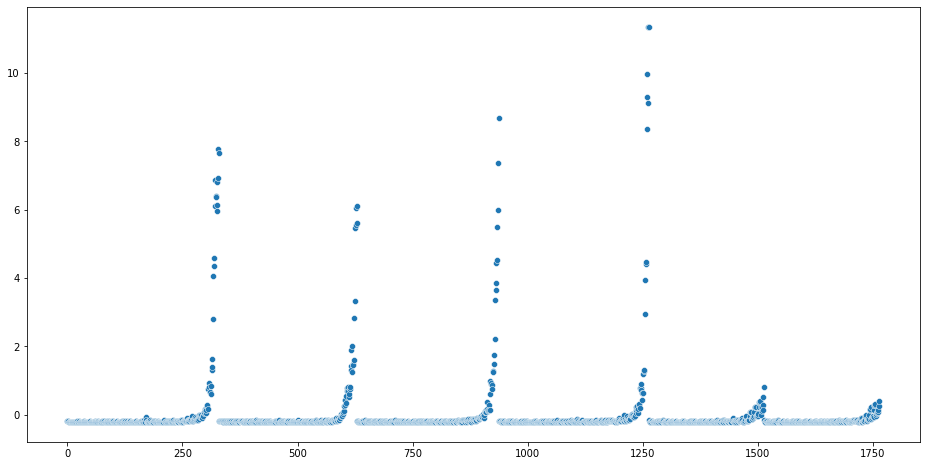

In [ ]:
# z-score
model_ae = load_model('best_ae_model.h5')
reconstruction = model_ae.predict(test_data)

mse = np.mean(np.power(test_data-reconstruction,2),axis=1)

import scipy.stats as ss
z_score = ss.zscore(mse)

plt.rcParams['figure.figsize']=(16,8)
sns.scatterplot(test_data.index,z_score)

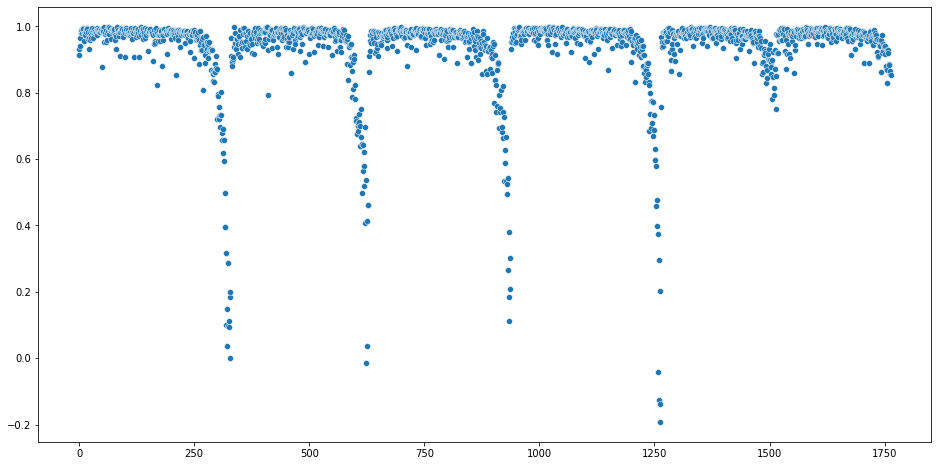

In [ ]:
# cosine similarity
import numpy as np
from numpy.linalg import norm

def cos_sim(A, B):
  return np.dot(A, B)/(norm(A)*norm(B))

reconstruction_df = pd.DataFrame(reconstruction)
cos_score=[]
for i in range(len(test_data)):
    cos=cos_sim(test_data.iloc[i,],reconstruction_df.iloc[i,])
    cos_score.append(cos)

sns.scatterplot(test_data.index,cos_score)

In [71]:
%%shell
jupyter nbconvert --to html /content/model.ipynb

[NbConvertApp] Converting notebook /content/model.ipynb to html
[NbConvertApp] Writing 1277498 bytes to /content/model.html
